In [19]:
import mlflow
import matplotlib.pyplot as plt
import matplotlib

import seaborn as sns
sns.set()

import sys
sys.path.append('../')

mlflow.set_tracking_uri('http://localhost:5001')

In [20]:
runs = mlflow.search_runs(filter_string=f"tags.type_of_run = 'varying_number_of_labels'",
                                           run_view_type=mlflow.tracking.client.ViewType.ACTIVE_ONLY,
                                           experiment_ids=['1', '2', '4'])

In [21]:
best_full_supervised = mlflow.search_runs(experiment_ids=['2'], 
                                          run_view_type=mlflow.tracking.client.ViewType.ACTIVE_ONLY)

In [22]:
best_full_supervised_acc = best_full_supervised['metrics.acc_top1'].max()
best_full_supervised_acc

99.89583333333333

In [23]:
grouped_max = runs.groupby(['experiment_id', 'params.n_labels_train', 'params.ema_decay'])['metrics.acc_top1'].agg([max, min, 'mean'])
grouped_max = grouped_max.stack()
grouped_max = grouped_max.rename('value')
grouped_max.index = grouped_max.index.rename('agg', level=3)
grouped_max = grouped_max.reset_index()

In [24]:
grouped_max['params.n_labels_train'] = grouped_max['params.n_labels_train'].astype(int)
grouped_max['experiment_id'] = grouped_max['experiment_id'].map({'1': 'mix-match', 
                                                                 '2': 'transfer learning', 
                                                                 '4': 'fix-match'})
grouped_max['experiment_id'] = grouped_max['experiment_id'] + ' (ema_decay = ' + grouped_max['params.ema_decay'] + ')'
grouped_max

,experiment_id,params.n_labels_train,params.ema_decay,agg,value
0,mix-match (ema_decay = 0.0),100,0.0,max,75.729167
1,mix-match (ema_decay = 0.0),100,0.0,min,73.541667
2,mix-match (ema_decay = 0.0),100,0.0,mean,74.635417
3,mix-match (ema_decay = 0.999),100,0.999,max,81.979167
4,mix-match (ema_decay = 0.999),100,0.999,min,63.958333
...,...,...,...,...,...
121,fix-match (ema_decay = 0.0),800,0.0,min,97.070312
122,fix-match (ema_decay = 0.0),800,0.0,mean,97.705078
123,fix-match (ema_decay = 0.999),800,0.999,max,98.046875
124,fix-match (ema_decay = 0.999),800,0.999,min,96.972656


In [25]:
grouped_max[grouped_max['params.n_labels_train'] == 200]

,experiment_id,params.n_labels_train,params.ema_decay,agg,value
6,mix-match (ema_decay = 0.0),200,0.0,max,92.500000
7,mix-match (ema_decay = 0.0),200,0.0,min,91.666667
8,mix-match (ema_decay = 0.0),200,0.0,mean,92.083333
9,mix-match (ema_decay = 0.999),200,0.999,max,87.187500
10,mix-match (ema_decay = 0.999),200,0.999,min,85.104167
11,mix-match (ema_decay = 0.999),200,0.999,mean,86.145833
48,transfer learning (ema_decay = 0.0),200,0.0,max,90.520833
49,transfer learning (ema_decay = 0.0),200,0.0,min,75.208333
50,transfer learning (ema_decay = 0.0),200,0.0,mean,82.877604
51,transfer learning (ema_decay = 0.999),200,0.999,max,53.229167


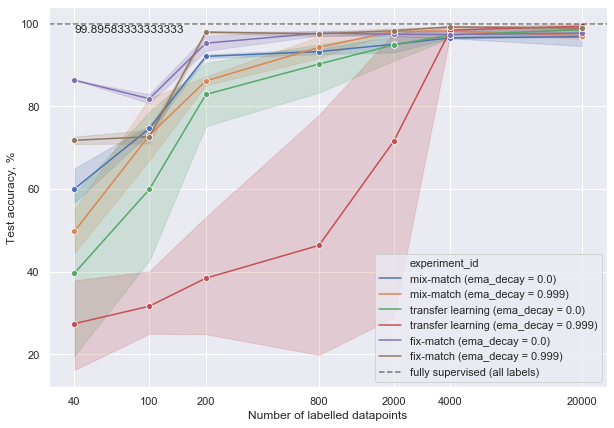

In [26]:
fig, ax = plt.subplots(1, 1, figsize = (10, 7))

sns.lineplot(x="params.n_labels_train", y="value", hue="experiment_id",
             data=grouped_max.reset_index(), marker='o', ax=ax)
ax.set_xscale('log')
ax.set_xticks(sorted(grouped_max['params.n_labels_train'].unique()))
ax.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
ax.axhline(best_full_supervised_acc, alpha=0.5, color='black', linestyle='--', label='fully supervised (all labels)')
ax.text(40, best_full_supervised_acc-2, f'{best_full_supervised_acc}')
ax.set_xlabel('Number of labelled datapoints')
ax.set_ylabel('Test accuracy, %')
plt.legend()

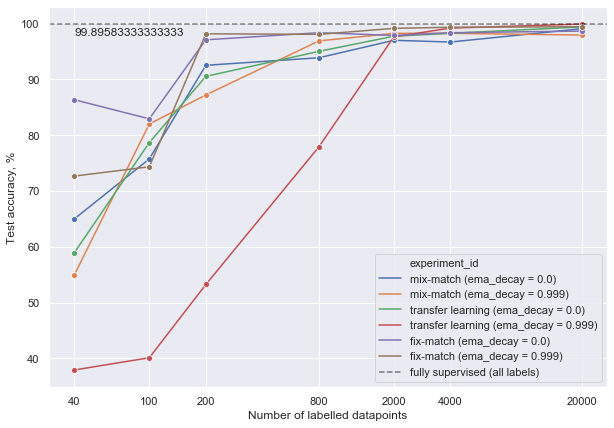

In [27]:
fig, ax = plt.subplots(1, 1, figsize = (10, 7))

sns.lineplot(x="params.n_labels_train", y="value", hue="experiment_id",
             data=grouped_max[grouped_max['agg'] == 'max'], marker='o', ax=ax)
ax.set_xscale('log')
ax.set_xticks(sorted(grouped_max['params.n_labels_train'].unique()))
ax.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
ax.axhline(best_full_supervised_acc, alpha=0.5, color='black', linestyle='--', label='fully supervised (all labels)')
ax.text(40, best_full_supervised_acc-2, f'{best_full_supervised_acc}')
ax.set_xlabel('Number of labelled datapoints')
ax.set_ylabel('Test accuracy, %')
plt.legend()